In [1]:
import pandas as pd
import numpy as np
from model import TransactionsRnn, TransactionsDataset, process_for_nn
from sklearn.model_selection import train_test_split
import torch
import pickle
from torch.utils.data import default_collate, DataLoader
from sklearn import metrics

df = pd.read_csv(
    'data/transactions_finetune.csv',
    parse_dates=["transaction_dttm"],
    dtype={"user_id": np.int32, "mcc_code": np.int16, "currency_rk": np.int8, "transaction_amt": float},
)
target = pd.read_csv('data/target_finetune.csv')

train_df = df[df.user_id <= 600000]
valid_df = df[df.user_id > 600000]

train_target = target[target.user_id <= 600000].sort_values('user_id')
valid_target = target[target.user_id > 600000].sort_values('user_id')

train_df.to_csv('data/train.csv', index=False)
valid_df.to_csv('data/valid.csv', index=False)

train_df = (
    train_df.dropna().assign(
        hour=lambda x: x.transaction_dttm.dt.hour,
        day=lambda x: x.transaction_dttm.dt.dayofweek,
        month=lambda x: x.transaction_dttm.dt.month,
        number_day=lambda x: x.transaction_dttm.dt.day,
    )
)
valid_df = (
    valid_df.dropna().assign(
        hour=lambda x: x.transaction_dttm.dt.hour,
        day=lambda x: x.transaction_dttm.dt.dayofweek,
        month=lambda x: x.transaction_dttm.dt.month,
        number_day=lambda x: x.transaction_dttm.dt.day,
    )
)

bins = pickle.load(open('nn_bins.pickle', 'rb'))
features = bins.pop('features')

train_df = process_for_nn(train_df, features, bins)
valid_df = process_for_nn(valid_df, features, bins)


train_ds = TransactionsDataset(train_df, dftarget=train_target)
valid_ds = TransactionsDataset(valid_df)

def collate_loader(x):
    return tuple(x_.to(device) for x_ in default_collate(x))

train_loader = DataLoader(train_ds, batch_size=200, shuffle=True, drop_last=True, collate_fn=collate_loader)
valid_loader = DataLoader(valid_ds, batch_size=200, shuffle=False, drop_last=False, collate_fn=collate_loader)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransactionsRnn()
model.load_state_dict(torch.load('nn_weights.ckpt'))
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()


model.eval()
start_preds = []
with torch.no_grad():
    for data, _ in valid_loader:
        output = model(data)
        start_preds.append(output.detach().cpu().numpy())
start_preds = np.concatenate(start_preds)[:, 1]
print(f'Start score: {round(metrics.roc_auc_score(valid_target["target"], start_preds), 6)}')


model.train()
for epoch in range(1):
    for data, cur_target in train_loader:
        optimizer.zero_grad()

        data, cur_target = data.to(device), cur_target.to(device)
        output = model(data)

        loss = criterion(output, cur_target)

        loss.backward()
        optimizer.step()


model.eval()
preds = []
with torch.no_grad():
    for data, _ in valid_loader:
        output = model(data)
        preds.append(output.detach().cpu().numpy())
preds = np.concatenate(preds)[:, 1]
print(f'End score: {round(metrics.roc_auc_score(valid_target["target"], preds), 6)}')

torch.save(model.state_dict(), 'nn_weights_new.ckpt')

Start score: 0.668464
End score: 0.67369


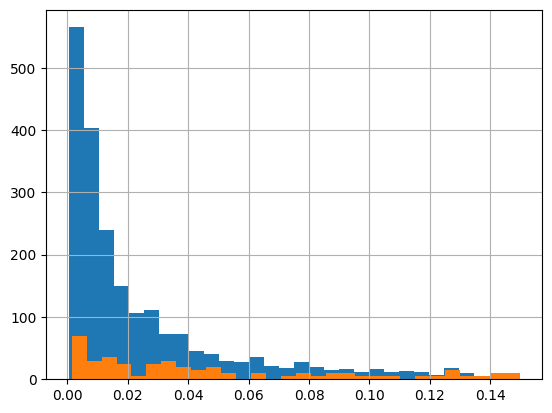

In [2]:
valid_target['pred'] = preds

cur_val_target = valid_target[valid_target.pred < 0.15]

import matplotlib.pyplot as plt
cur_val_target.pred.hist(bins=30)
plt.hist(cur_val_target[cur_val_target.target == 1].pred.tolist()*5, bins=30)
None